In [27]:
import numpy as np
import cv2
import os
from pdf2image import convert_from_path

# 수능완성 페이지 트림 (좌, 우 반 페이지 분리)
def imtrim(page):
    height, width = page.shape[:2]
    
    # 상단 여백 제거 위치
    y_start = 250  # 상단 여백 제거 위치 조정
    
    # 좌우 페이지 분할 위치 계산
    mid_point = width // 2  # 페이지 중앙점
    margin = 100  # 중앙 여백
    
    # 왼쪽 페이지
    x_left = 100  # 왼쪽 여백
    w_left = mid_point - x_left - margin +30
    left = page[y_start:, x_left:x_left+w_left]
    
    # 오른쪽 페이지
    x_right = mid_point + margin
    w_right = width - x_right - 100 +30 # 오른쪽 여백 100
    right = page[y_start:, x_right:x_right+w_right]
    
    return right, left

def contour(page_rl, save_path):
    # 이미지를 흑백으로 변환
    imgray = cv2.cvtColor(page_rl, cv2.COLOR_BGR2GRAY)
    
    # 문제 번호 찾기를 위한 이진화
    _, thresh = cv2.threshold(imgray, 200, 255, cv2.THRESH_BINARY_INV)
    
    # 문제 번호 영역 검출을 위한 커널 (작은 사이즈로 문제 번호 크기에 맞춤)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 20))
    dilated = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, kernel)
    
    # 문제 번호 검출
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # y좌표로 정렬
    number_positions = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        # 문제 번호의 특성에 맞는 크기 조건
        if 20 < w < 50 and 20 < h < 50 and x < 100:  # 문제 번호는 왼쪽에 있고 적당한 크기
            number_positions.append(y)
    
    number_positions.sort()
    
    # 문제 영역 추출
    for i in range(len(number_positions)):
        if i == len(number_positions) - 1:  # 마지막 문제
            y_start = max(0, number_positions[i] - 30)  # 번호 위로 여백
            y_end = page_rl.shape[0]  # 페이지 끝까지
        else:
            y_start = max(0, number_positions[i] - 30)  # 번호 위로 여백
            y_end = number_positions[i + 1] - 30  # 다음 번호 직전까지
        
        # 문제 영역 추출
        img_trim = page_rl[y_start:y_end, 0:page_rl.shape[1]]
        
        # 저장
        img_name = os.path.join(save_path, f"problem_{i}.png")
        cv2.imwrite(img_name, img_trim)
        print(f"문제 {i+1} 저장됨: {y_start} ~ {y_end}")
# 실행 부분
if __name__ == "__main__":
    # PDF 파일 경로와 저장할 폴더 경로 설정
    pdf_path = "C:/Users/user/Downloads/2024_pil_A.pdf"  # 처리할 PDF 파일 경로
    save_path = "C:/Users/user/Downloads/cropped_problems"  # 크롭된 문제를 저장할 폴더 경로

    # 문제 크롭 실행
    problem_crop_from_pdf(pdf_path, save_path)


페이지 1 이미지 저장: C:/Users/user/Downloads/cropped_problems\page_1.png
페이지 2 이미지 저장: C:/Users/user/Downloads/cropped_problems\page_2.png
문제 1 저장됨: 3824 ~ 4050
페이지 3 이미지 저장: C:/Users/user/Downloads/cropped_problems\page_3.png
문제 1 저장됨: 3786 ~ 3824
문제 2 저장됨: 3824 ~ 4050
페이지 4 이미지 저장: C:/Users/user/Downloads/cropped_problems\page_4.png
문제 1 저장됨: 3601 ~ 4050
페이지 5 이미지 저장: C:/Users/user/Downloads/cropped_problems\page_5.png
페이지 6 이미지 저장: C:/Users/user/Downloads/cropped_problems\page_6.png
페이지 7 이미지 저장: C:/Users/user/Downloads/cropped_problems\page_7.png
페이지 8 이미지 저장: C:/Users/user/Downloads/cropped_problems\page_8.png
문제 1 저장됨: 347 ~ 4050
페이지 9 이미지 저장: C:/Users/user/Downloads/cropped_problems\page_9.png
페이지 10 이미지 저장: C:/Users/user/Downloads/cropped_problems\page_10.png
문제 1 저장됨: 3821 ~ 4050
페이지 11 이미지 저장: C:/Users/user/Downloads/cropped_problems\page_11.png
문제 1 저장됨: 25 ~ 3825
문제 2 저장됨: 3825 ~ 4050
페이지 12 이미지 저장: C:/Users/user/Downloads/cropped_problems\page_12.png
문제 1 저장됨: 256 ~ 3824
문제 2 저장됨

In [29]:
def count_problems(page_rl):
    # 이미지를 흑백으로 변환
    imgray = cv2.cvtColor(page_rl, cv2.COLOR_BGR2GRAY)
    
    # 전체 영역에서 작업 (왼쪽 여백으로 제한하지 않음)
    # 이진화 - 배경은 흰색, 텍스트는 검은색으로
    _, thresh = cv2.threshold(imgray, 180, 255, cv2.THRESH_BINARY_INV)
    
    # 노이즈 제거
    kernel = np.ones((3,3), np.uint8)
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    
    # 연결 요소 레이블링
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(cleaned)
    
    # 문제 번호 위치 저장
    problem_positions = []
    
    # 각 연결 요소 분석
    for i in range(1, num_labels):  # 0은 배경이므로 제외
        x, y, w, h, area = stats[i]
        
        # 문제 번호의 예상 특성
        if (20 < w < 50 and 20 < h < 50  # 크기 제한
            and x < 150  # 왼쪽에 위치
            and area > 100 and area < 1000):  # 면적 제한
            
            # 디버깅을 위한 사각형 그리기
            cv2.rectangle(page_rl, (x, y), (x+w, y+h), (0, 0, 255), 2)
            problem_positions.append((y, x))
    
    # 디버깅용 이미지 저장
    cv2.imwrite(f'debug_numbers_{len(problem_positions)}.png', page_rl)
    
    # y 좌표로 정렬
    problem_positions.sort()
    
    return len(problem_positions)
# PDF 파일을 이미지로 변환 후, 문제 수 파악
def analyze_pdf(pdf_path):
    # PDF 파일을 이미지로 변환
    pages = convert_from_path(pdf_path, dpi=300)
    
    for page_num, page in enumerate(pages):
        # PIL Image를 OpenCV 형식으로 변환
        page_cv = cv2.cvtColor(np.array(page), cv2.COLOR_RGB2BGR)
        
        # 페이지 분할
        right, left = imtrim(page_cv)
        
        # 각 반페이지의 문제 수 계산
        right_problems = count_problems(right)
        left_problems = count_problems(left)
        
        print(f"페이지 {page_num + 1}:")
        print(f"  왼쪽: {left_problems} 문제")
        print(f"  오른쪽: {right_problems} 문제")

# 실행
if __name__ == "__main__":
    pdf_path = "C:/Users/user/Downloads/2024_pil_A.pdf"
    analyze_pdf(pdf_path)

페이지 1:
  왼쪽: 0 문제
  오른쪽: 10 문제
페이지 2:
  왼쪽: 0 문제
  오른쪽: 7 문제
페이지 3:
  왼쪽: 0 문제
  오른쪽: 9 문제
페이지 4:
  왼쪽: 0 문제
  오른쪽: 10 문제
페이지 5:
  왼쪽: 0 문제
  오른쪽: 12 문제
페이지 6:
  왼쪽: 0 문제
  오른쪽: 6 문제
페이지 7:
  왼쪽: 0 문제
  오른쪽: 14 문제
페이지 8:
  왼쪽: 0 문제
  오른쪽: 14 문제
페이지 9:
  왼쪽: 0 문제
  오른쪽: 8 문제
페이지 10:
  왼쪽: 0 문제
  오른쪽: 5 문제
페이지 11:
  왼쪽: 0 문제
  오른쪽: 5 문제
페이지 12:
  왼쪽: 0 문제
  오른쪽: 3 문제
페이지 13:
  왼쪽: 0 문제
  오른쪽: 2 문제
페이지 14:
  왼쪽: 0 문제
  오른쪽: 0 문제


In [35]:
def imtrim(page):
    height, width = page.shape[:2]
    
    # 페이지 중앙을 기준으로 분할
    mid_point = width // 2
    
    # 왼쪽 페이지
    left = page[:, :mid_point]
    
    # 오른쪽 페이지
    right = page[:, mid_point:]
    
    # 디버깅을 위해 분할된 이미지 저장
    cv2.imwrite('debug_left.png', left)
    cv2.imwrite('debug_right.png', right)
    
    return right, left

def count_problems(page_rl):
    # 이미지를 흑백으로 변환
    imgray = cv2.cvtColor(page_rl, cv2.COLOR_BGR2GRAY)
    
    # 이진화 - 더 강한 대비를 위해 임계값 조정
    _, thresh = cv2.threshold(imgray, 210, 255, cv2.THRESH_BINARY_INV)
    
    # 노이즈 제거를 위한 모폴로지 연산
    kernel = np.ones((2,2), np.uint8)
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    
    # 디버깅용 이미지
    debug_img = cv2.cvtColor(cleaned.copy(), cv2.COLOR_GRAY2BGR)
    
    # 연결 요소 분석
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    problem_positions = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        
        # 문제 번호의 특성 확인
        # 1. 왼쪽에 위치 (x < 100)
        # 2. 적절한 크기 (너비와 높이가 비슷한 정사각형에 가까움)
        # 3. 적절한 종횡비
        aspect_ratio = float(w)/h
        
        if (x < 100 and  # 왼쪽 여백 내
            15 < w < 35 and 15 < h < 35 and  # 크기 제한
            0.8 < aspect_ratio < 1.2):  # 정사각형에 가까움
            
            # 디버깅을 위한 시각화
            cv2.rectangle(debug_img, (x,y), (x+w,y+h), (0,0,255), 2)
            cv2.putText(debug_img, f'{w}x{h}', (x,y-5), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
            
            problem_positions.append(y)
    
    # y 좌표로 정렬
    problem_positions.sort()
    
    # 디버깅 이미지 저장 - 페이지 구분을 위해 타임스탬프 추가
    timestamp = int(time.time())
    cv2.imwrite(f'debug_detection_{timestamp}.png', debug_img)
    
    return len(problem_positions)

In [39]:

# PDF 파일을 이미지로 변환 후, 문제 크롭 실행
def problem_crop_from_pdf(pdf_path, save_path):
    # PDF 파일을 이미지로 변환
    pages = convert_from_path(pdf_path, dpi=300)

    # 저장할 폴더가 없으면 생성
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    # PDF 페이지를 저장할 서브 폴더 'pages' 생성
    pages_folder = os.path.join(save_path, 'pages')
    if not os.path.exists(pages_folder):
        os.makedirs(pages_folder)

    # 문제 이미지를 저장할 서브 폴더 'problems' 생성
    problems_folder = os.path.join(save_path, 'problems')
    if not os.path.exists(problems_folder):
        os.makedirs(problems_folder)

    # 각 페이지에 대해 처리
    for page_num, page in enumerate(pages):
        # 페이지 이미지를 PIL Image 객체로 변환
        page_image = page
        
        # 이미지 크기 가져오기
        width, height = page_image.size
        
        # 왼쪽 절반과 오른쪽 절반으로 나누기
        left_half = page_image.crop((0, 0, width//2, height))
        right_half = page_image.crop((width//2, 0, width, height))
        
        # 각 절반 이미지 저장
        left_half_path = os.path.join(problems_folder, f"page_{page_num + 1}_left.png")
        right_half_path = os.path.join(problems_folder, f"page_{page_num + 1}_right.png")
        
        left_half.save(left_half_path, 'PNG')
        right_half.save(right_half_path, 'PNG')
        
        # 원본 페이지도 저장
        page_image_path = os.path.join(pages_folder, f"page_{page_num + 1}.png")
        page_image.save(page_image_path, 'PNG')
        
        print(f"페이지 {page_num + 1} 처리 완료:")
        print(f"- 원본 저장: {page_image_path}")
        print(f"- 왼쪽 절반 저장: {left_half_path}")
        print(f"- 오른쪽 절반 저장: {right_half_path}")

problem_crop_from_pdf("C:/Users/user/Downloads/2024_pil_A.pdf","C:/Users/user/Downloads/")



problem_crop_from_pdf("C:/Users/user/Downloads/2024_pil_A.pdf","C:/Users/user/Downloads/")

페이지 1 처리 완료:
- 원본 저장: C:/Users/user/Downloads/pages\page_1.png
- 왼쪽 절반 저장: C:/Users/user/Downloads/problems\page_1_left.png
- 오른쪽 절반 저장: C:/Users/user/Downloads/problems\page_1_right.png
페이지 2 처리 완료:
- 원본 저장: C:/Users/user/Downloads/pages\page_2.png
- 왼쪽 절반 저장: C:/Users/user/Downloads/problems\page_2_left.png
- 오른쪽 절반 저장: C:/Users/user/Downloads/problems\page_2_right.png
페이지 3 처리 완료:
- 원본 저장: C:/Users/user/Downloads/pages\page_3.png
- 왼쪽 절반 저장: C:/Users/user/Downloads/problems\page_3_left.png
- 오른쪽 절반 저장: C:/Users/user/Downloads/problems\page_3_right.png
페이지 4 처리 완료:
- 원본 저장: C:/Users/user/Downloads/pages\page_4.png
- 왼쪽 절반 저장: C:/Users/user/Downloads/problems\page_4_left.png
- 오른쪽 절반 저장: C:/Users/user/Downloads/problems\page_4_right.png
페이지 5 처리 완료:
- 원본 저장: C:/Users/user/Downloads/pages\page_5.png
- 왼쪽 절반 저장: C:/Users/user/Downloads/problems\page_5_left.png
- 오른쪽 절반 저장: C:/Users/user/Downloads/problems\page_5_right.png
페이지 6 처리 완료:
- 원본 저장: C:/Users/user/Downloads/pages\page_6.png
- 

In [40]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def analyze_dark_pixels(image_path, y_target, threshold=100):
    """
    Analyze dark pixels along the x-axis for a given y-coordinate in an image.

    Parameters:
        image_path (str): Path to the input image file.
        y_target (int): The y-coordinate to analyze.
        threshold (int): The intensity threshold to detect dark pixels.

    Returns:
        list: X-coordinates where dark pixels are detected.
    """
    # Load and convert the image to grayscale
    image = Image.open(image_path)
    gray_image = image.convert("L")
    gray_array = np.array(gray_image)

    # Extract the pixel intensities along the x-axis for the given y-coordinate
    vertical_line = gray_array[y_target, :]

    # Detect positions of dark pixels (intensity < threshold)
    dark_pixel_positions = np.where(vertical_line < threshold)[0]

    # Visualize the results
    plt.figure(figsize=(10, 4))
    plt.plot(range(len(vertical_line)), vertical_line, label="Pixel Intensity")
    plt.scatter(dark_pixel_positions, vertical_line[dark_pixel_positions], color='red', label="Dark Pixels (<Threshold)")
    plt.title(f"Pixel Intensity Along X-axis at Y={y_target}")
    plt.xlabel("X-coordinate")
    plt.ylabel("Pixel Intensity")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return the detected dark pixel positions
    return dark_pixel_positions.tolist()


# Example usage
image_path = "/mnt/data/page_14_left.png"  # Path to the image
y_target = 71  # Target y-coordinate to analyze
threshold = 100  # Intensity threshold for detecting dark pixels

# Perform the analysis
dark_pixels = analyze_dark_pixels(image_path, y_target, threshold)

print(f"Dark pixels detected at x-coordinates: {dark_pixels}")


In [43]:
# 예제 이미지 경로
image_path = r"C:\Users\user\Downloads\problems\page_14_left.png"
detect_black_pixels(image_path)


검정색 픽셀 발견: 위치 (x=849, y=444)
검정색 픽셀 발견: 위치 (x=943, y=444)
검정색 픽셀 발견: 위치 (x=1060, y=444)
검정색 픽셀 발견: 위치 (x=424, y=445)
검정색 픽셀 발견: 위치 (x=530, y=445)
검정색 픽셀 발견: 위치 (x=531, y=445)
검정색 픽셀 발견: 위치 (x=577, y=445)
검정색 픽셀 발견: 위치 (x=623, y=445)
검정색 픽셀 발견: 위치 (x=737, y=445)
검정색 픽셀 발견: 위치 (x=784, y=445)
검정색 픽셀 발견: 위치 (x=785, y=445)
검정색 픽셀 발견: 위치 (x=786, y=445)
검정색 픽셀 발견: 위치 (x=851, y=445)
검정색 픽셀 발견: 위치 (x=852, y=445)
검정색 픽셀 발견: 위치 (x=947, y=445)
검정색 픽셀 발견: 위치 (x=1063, y=445)
검정색 픽셀 발견: 위치 (x=1153, y=445)
검정색 픽셀 발견: 위치 (x=1222, y=445)
검정색 픽셀 발견: 위치 (x=1267, y=445)
검정색 픽셀 발견: 위치 (x=1269, y=445)
검정색 픽셀 발견: 위치 (x=1475, y=445)
검정색 픽셀 발견: 위치 (x=1477, y=445)
검정색 픽셀 발견: 위치 (x=331, y=446)
검정색 픽셀 발견: 위치 (x=340, y=446)
검정색 픽셀 발견: 위치 (x=578, y=446)
검정색 픽셀 발견: 위치 (x=580, y=446)
검정색 픽셀 발견: 위치 (x=625, y=446)
검정색 픽셀 발견: 위치 (x=739, y=446)
검정색 픽셀 발견: 위치 (x=740, y=446)
검정색 픽셀 발견: 위치 (x=786, y=446)
검정색 픽셀 발견: 위치 (x=788, y=446)
검정색 픽셀 발견: 위치 (x=854, y=446)
검정색 픽셀 발견: 위치 (x=855, y=446)
검정색 픽셀 발견: 위치 (x=890, y=446)
검정색 픽셀

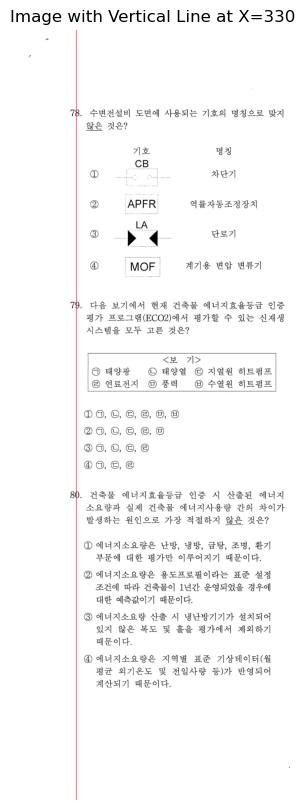

In [51]:
import cv2
import matplotlib.pyplot as plt

def overlay_x_line(image_path, x_target, output_path="output_with_x_line.png"):
    """
    Overlay a vertical line at a specific x-coordinate on the image.

    Parameters:
        image_path (str): Path to the input image file.
        x_target (int): The x-coordinate where the line will be overlaid.
        output_path (str): Path to save the output image with the overlay.

    Returns:
        None
    """
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    if image is None:
        print("Failed to load image.")
        return

    # Add a vertical line at x_target (BGR color: red)
    line_color = (0, 0, 255)  # Red color in BGR
    line_thickness = 2
    image_with_line = cv2.line(image, (x_target, 0), (x_target, image.shape[0]), line_color, line_thickness)

    # Save the output image with the overlay
    cv2.imwrite(output_path, image_with_line)

    # Display the image with the overlay
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_with_line, cv2.COLOR_BGR2RGB))
    plt.title(f"Image with Vertical Line at X={x_target}")
    plt.axis("off")
    plt.show()

# Example usage
x_target = 330  # Example x-coordinate to overlay the line
overlay_x_line(image_path, x_target)


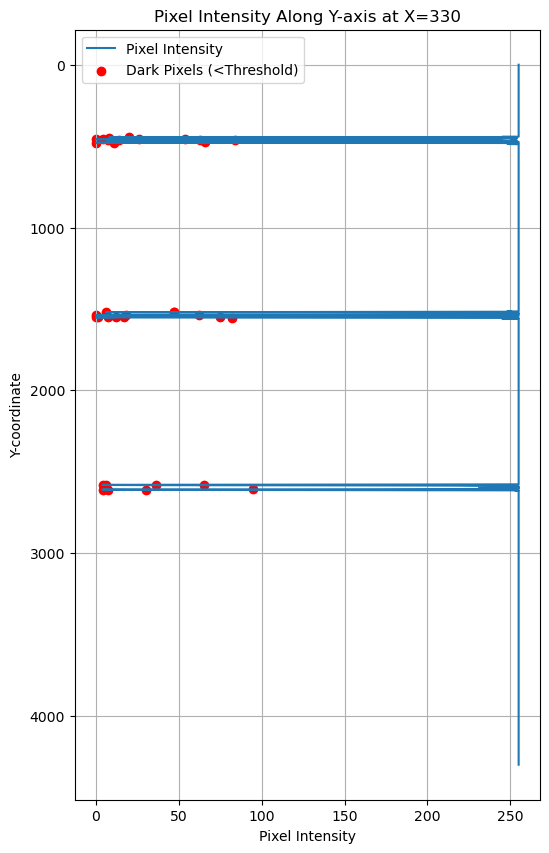

Dark pixels detected at y-coordinates: [446, 447, 456, 457, 458, 459, 460, 463, 464, 465, 477, 478, 479, 1519, 1520, 1521, 1537, 1538, 1539, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 2579, 2580, 2581, 2582, 2608, 2609, 2610, 2611]


In [52]:
import cv2
import numpy as np

def analyze_vertical_line(image_path, x_target, threshold=100):
    """
    Analyze pixels along the y-axis for a given x-coordinate in an image.

    Parameters:
        image_path (str): Path to the input image file.
        x_target (int): The x-coordinate to analyze.
        threshold (int): The intensity threshold to detect dark pixels.

    Returns:
        list: Y-coordinates where dark pixels are detected.
    """
    # Load the image using OpenCV
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale for intensity analysis
    if image is None:
        print("Failed to load image.")
        return

    # Extract the pixel intensities along the y-axis at x_target
    vertical_line = image[:, x_target]

    # Detect positions of dark pixels (intensity < threshold)
    dark_pixel_positions = np.where(vertical_line < threshold)[0]

    # Visualize the pixel intensity along the y-axis
    plt.figure(figsize=(6, 10))
    plt.plot(vertical_line, range(len(vertical_line)), label="Pixel Intensity")
    plt.scatter(vertical_line[dark_pixel_positions], dark_pixel_positions, color='red', label="Dark Pixels (<Threshold)")
    plt.gca().invert_yaxis()  # Match image coordinate system
    plt.title(f"Pixel Intensity Along Y-axis at X={x_target}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Y-coordinate")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return the detected y-coordinates of dark pixels
    return dark_pixel_positions.tolist()


# Example usage
x_target = 330  # x-coordinate to analyze
threshold = 100  # Intensity threshold for detecting dark pixels
dark_pixels = analyze_vertical_line(image_path, x_target, threshold)

print(f"Dark pixels detected at y-coordinates: {dark_pixels}")


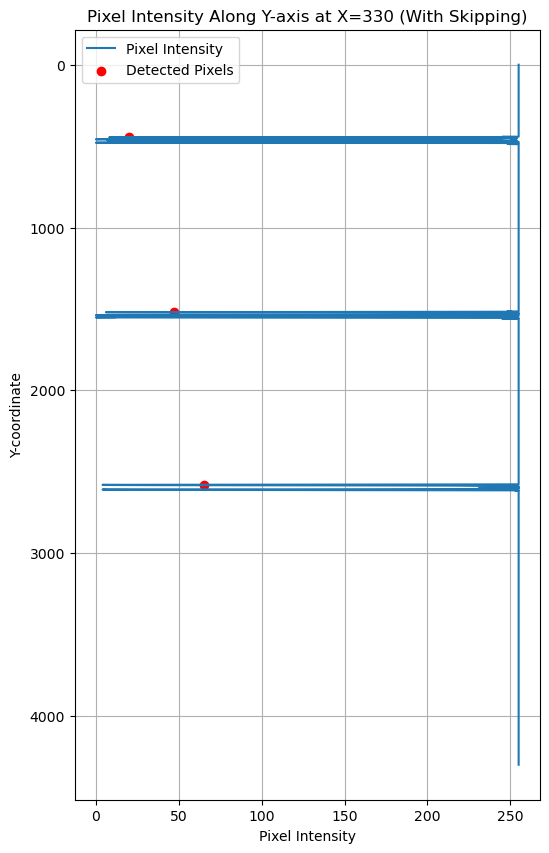

Dark pixels detected at y-coordinates: [446, 1519, 2579]


In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def analyze_vertical_line_with_skip(image_path, x_target, threshold=100, skip=60):
    """
    Analyze pixels along the y-axis for a given x-coordinate in an image,
    skipping a defined number of pixels after each detection.

    Parameters:
        image_path (str): Path to the input image file.
        x_target (int): The x-coordinate to analyze.
        threshold (int): The intensity threshold to detect dark pixels.
        skip (int): Number of pixels to skip after detecting a dark pixel.

    Returns:
        list: Y-coordinates where dark pixels are detected.
    """
    # Load the image using OpenCV
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale for intensity analysis
    if image is None:
        print("Failed to load image.")
        return

    # Extract the pixel intensities along the y-axis at x_target
    vertical_line = image[:, x_target]

    # Initialize variables
    dark_pixel_positions = []  # List to store detected dark pixel positions
    y = 0  # Start from the top of the image

    while y < len(vertical_line):
        if vertical_line[y] < threshold:
            # Dark pixel detected, add its position
            dark_pixel_positions.append(y)
            # Skip the next `skip` pixels
            y += skip
        else:
            # Move to the next pixel
            y += 1

    # Visualize the pixel intensity along the y-axis
    plt.figure(figsize=(6, 10))
    plt.plot(vertical_line, range(len(vertical_line)), label="Pixel Intensity")
    plt.scatter(vertical_line[dark_pixel_positions], dark_pixel_positions, color='red', label="Detected Pixels")
    plt.gca().invert_yaxis()  # Match image coordinate system
    plt.title(f"Pixel Intensity Along Y-axis at X={x_target} (With Skipping)")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Y-coordinate")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return the detected y-coordinates of dark pixels
    return dark_pixel_positions


# Example usage
x_target = 330  # x-coordinate to analyze
threshold = 100  # Intensity threshold for detecting dark pixels
skip = 60  # Number of pixels to skip after detection
dark_pixels = analyze_vertical_line_with_skip(image_path, x_target, threshold, skip)

print(f"Dark pixels detected at y-coordinates: {dark_pixels}")


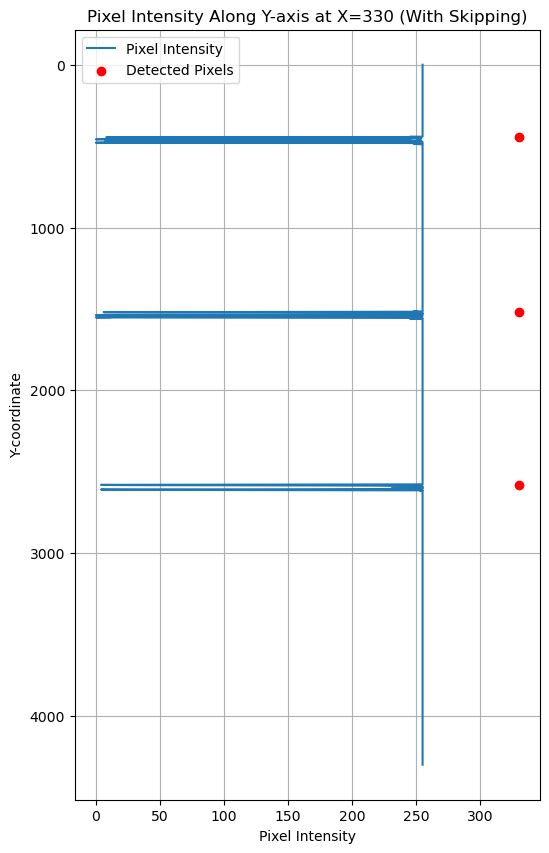

Detected (x, y) coordinates of dark pixels:
(330, 446)
(330, 1519)
(330, 2579)


In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def analyze_vertical_line_with_skip(image_path, x_target, threshold=100, skip=60):
    """
    Analyze pixels along the y-axis for a given x-coordinate in an image,
    skipping a defined number of pixels after each detection.

    Parameters:
        image_path (str): Path to the input image file.
        x_target (int): The x-coordinate to analyze.
        threshold (int): The intensity threshold to detect dark pixels.
        skip (int): Number of pixels to skip after detecting a dark pixel.

    Returns:
        list: Detected (x, y) coordinates of dark pixels.
    """
    # Load the image using OpenCV
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale for intensity analysis
    if image is None:
        print("Failed to load image.")
        return

    # Extract the pixel intensities along the y-axis at x_target
    vertical_line = image[:, x_target]

    # Initialize variables
    dark_pixel_positions = []  # List to store detected dark pixel positions
    y = 0  # Start from the top of the image

    while y < len(vertical_line):
        if vertical_line[y] < threshold:
            # Dark pixel detected, add its (x, y) position
            dark_pixel_positions.append((x_target, y))
            # Skip the next `skip` pixels
            y += skip
        else:
            # Move to the next pixel
            y += 1

    # Visualize the pixel intensity along the y-axis
    plt.figure(figsize=(6, 10))
    plt.plot(vertical_line, range(len(vertical_line)), label="Pixel Intensity")
    plt.scatter([x_target] * len(dark_pixel_positions), [y for _, y in dark_pixel_positions], color='red', label="Detected Pixels")
    plt.gca().invert_yaxis()  # Match image coordinate system
    plt.title(f"Pixel Intensity Along Y-axis at X={x_target} (With Skipping)")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Y-coordinate")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return the detected (x, y) coordinates of dark pixels
    return dark_pixel_positions


# Example usage
x_target = 330  # x-coordinate to analyze
threshold = 100  # Intensity threshold for detecting dark pixels
skip = 60  # Number of pixels to skip after detection
dark_pixels = analyze_vertical_line_with_skip(image_path, x_target, threshold, skip)

print("Detected (x, y) coordinates of dark pixels:")
for coord in dark_pixels:
    print(coord)


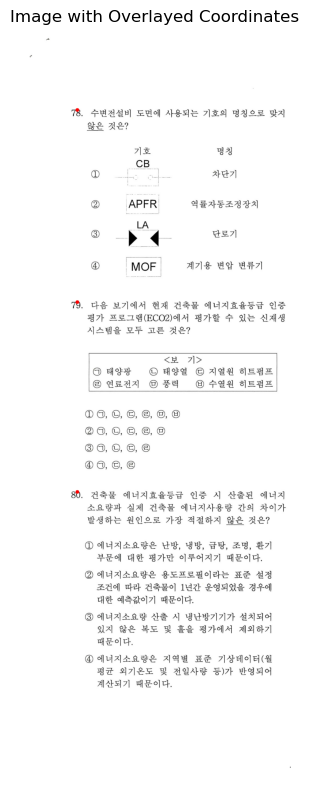

In [55]:
import cv2
import matplotlib.pyplot as plt

def overlay_coordinates(image_path, coordinates, output_path="output_with_coordinates.png"):
    """
    Overlay specified coordinates on the image.

    Parameters:
        image_path (str): Path to the input image file.
        coordinates (list of tuples): List of (x, y) coordinates to overlay.
        output_path (str): Path to save the output image with the overlay.

    Returns:
        None
    """
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    if image is None:
        print("Failed to load image.")
        return

    # Overlay each coordinate as a circle on the image
    for (x, y) in coordinates:
        # Draw a circle at each (x, y) coordinate (BGR color: red)
        circle_color = (0, 0, 255)  # Red color in BGR
        circle_radius = 10
        circle_thickness = -1  # Filled circle
        cv2.circle(image, (x, y), circle_radius, circle_color, circle_thickness)

    # Save the output image with the overlay
    cv2.imwrite(output_path, image)

    # Display the image with the overlay
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Image with Overlayed Coordinates")
    plt.axis("off")
    plt.show()

# Example usage
coordinates = [(330, 446), (330, 1519), (330, 2579)]  # List of coordinates to overlay
overlay_coordinates(image_path, coordinates)
